###Khai báo thư viện



In [1]:
import os
import pandas as pd
import numpy as np
from functools import reduce

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

!pip install shap
import shap

import joblib

##Tiền xử lý dữ liệu


###Đọc các file dữ liệu


In [2]:
df_vnd  = pd.read_csv("/content/Dữ liệu USD_VND.csv")
df_cny  = pd.read_csv("/content/Dữ liệu Lịch sử CNY_USD.csv")
df_dxy  = pd.read_csv("/content/Dữ liệu Lịch sử Chỉ số Đô la Mỹ.csv")
df_gold = pd.read_csv("/content/Dữ liệu Lịch sử Hợp đồng Tương lai Vàng.csv")
df_bond = pd.read_csv("/content/Dữ liệu Lịch sử Suất Thu lợi Trái phiếu 10 Năm Việt Nam.csv")
df_cpi  = pd.read_csv("/content/Dữ liệu CPI.csv")
df_dff  = pd.read_csv("/content/Fed Funds Rate.csv")

In [3]:
#Xác định các cột ở mỗi file
df_vnd.columns, df_cny.columns, df_dxy.columns, df_gold.columns,
df_bond.columns, df_cpi.columns, df_dff.columns


(Index(['Ngày', 'Lần cuối', 'Mở', 'Cao', 'Thấp', '% Thay đổi'], dtype='object'),
 Index(['Ngày', 'CPI'], dtype='object'),
 Index(['Ngày', 'DFF'], dtype='object'))

In [4]:
# Dữ lại dữ liệu cần thiết và đổi tên cột 'Lần cuối' cho từng DataFrame
df_vnd = df_vnd[["Ngày", "Lần cuối"]].rename(columns={'Lần cuối': 'Lần cuối_vnd'})
df_cny = df_cny[["Ngày", "Lần cuối"]].rename(columns={'Lần cuối': 'Lần cuối_cny'})
df_dxy = df_dxy[["Ngày", "Lần cuối"]].rename(columns={'Lần cuối': 'Lần cuối_dxy'})
df_gold = df_gold[["Ngày", "Lần cuối"]].rename(columns={'Lần cuối': 'Lần cuối_gold'})
df_bond = df_bond[["Ngày", "Lần cuối"]].rename(columns={'Lần cuối': 'Lần cuối_bond'})



In [5]:
def normalize_datetime_index(df, date_col='Ngày'):
    df = df.copy()

    # Nếu chưa phải DatetimeIndex thì chuẩn hóa
    if not isinstance(df.index, pd.DatetimeIndex):
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
            df = df.set_index(date_col)

    # Làm sạch index
    df = df[df.index.notna()]
    df = df[~df.index.duplicated(keep='last')]
    df = df.sort_index()

    return df
df_vnd  = normalize_datetime_index(df_vnd)
df_cny  = normalize_datetime_index(df_cny)
df_dxy  = normalize_datetime_index(df_dxy)
df_gold = normalize_datetime_index(df_gold)
df_bond = normalize_datetime_index(df_bond)
df_dff  = normalize_datetime_index(df_dff)
df_cpi  = normalize_datetime_index(df_cpi)

for name, df_ in {
    'vnd': df_vnd, 'cny': df_cny, 'dxy': df_dxy,
    'gold': df_gold, 'bond': df_bond,
    'dff': df_dff
}.items():
    print(name, type(df_.index))

vnd <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
cny <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
dxy <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
gold <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
bond <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
dff <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


###Xử lý dữ liệu CPI


In [6]:
# Đặt cột 'Ngày' làm chỉ mục trước khi thực hiện resample
if 'Ngày' in df_cpi.columns:
    df_cpi.set_index('Ngày', inplace=True)
if not isinstance(df_cpi.index, pd.DatetimeIndex):
    df_cpi.index = pd.to_datetime(df_cpi.index, dayfirst=True)

# Loại bỏ dữ liệu không hợp lệ (nếu có NaT do to_datetime)
df_cpi = df_cpi[df_cpi.index.notna()]
# Loại bỏ các ngày trùng lặp
df_cpi = df_cpi[~df_cpi.index.duplicated(keep='last')]
df_cpi = df_cpi.resample('D').ffill()
df_cpi

,CPI
Ngày,
2008-01-01,"102,38"
2008-01-02,"102,38"
2008-01-03,"102,38"
2008-01-04,"102,38"
2008-01-05,"102,38"
...,...
2024-11-27,"100,13"
2024-11-28,"100,13"
2024-11-29,"100,13"


In [7]:
print(type(df_vnd.index))
print(type(df_cny.index))
print(type(df_dxy.index))
print(type(df_gold.index))
print(type(df_bond.index))
print(type(df_dff.index))
print(type(df_cpi.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


###Gộp dữ liệu vào một dataframe


In [8]:
# Gộp tất cả các DataFrame đã được xử lý (với DatetimeIndex)
df = df_vnd.copy()
df = (
    df.merge(df_cny, left_index=True, right_index=True, how='left')
      .merge(df_dxy, left_index=True, right_index=True, how='left')
      .merge(df_gold, left_index=True, right_index=True, how='left')
      .merge(df_bond, left_index=True, right_index=True, how='left')
      .merge(df_dff, left_index=True, right_index=True, how='left')
      .merge(df_cpi, left_index=True, right_index=True, how='left')
)

In [9]:
df = df.sort_index()
# Chuyển đổi index sang kiểu DatetimeIndex sau khi gộp và sắp xếp
df.index = pd.to_datetime(df.index, dayfirst=True)

# Chuyển dữ liệu sang dạng số
for col in ['Lần cuối_vnd', 'Lần cuối_cny', 'Lần cuối_dxy', 'Lần cuối_gold', 'Lần cuối_bond', 'DFF', 'CPI']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

df.head()

,Lần cuối_vnd,Lần cuối_cny,Lần cuối_dxy,Lần cuối_gold,Lần cuối_bond,DFF,CPI
Ngày,,,,,,,
2008-01-01,16018.0,0.1369,NaN,NaN,NaN,3.06,10238.0
2008-01-02,15985.0,0.1371,75.97,860.0,NaN,4.11,10238.0
2008-01-03,15985.0,0.1375,75.89,869.1,NaN,4.25,10238.0
2008-01-04,15980.0,0.1375,75.79,865.7,NaN,4.18,10238.0
2008-01-07,15975.0,0.1376,76.17,862.0,NaN,4.27,10238.0


###Xây dựng các đặc trưng

In [10]:
base_cols = ['Lần cuối_vnd', 'Lần cuối_cny', 'Lần cuối_dxy', 'Lần cuối_gold', 'Lần cuối_bond', 'DFF', 'CPI']

for col in base_cols:
    df[f'{col}_ret'] = df[col].pct_change()

/tmp/ipython-input-4013425019.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_ret'] = df[col].pct_change()
/tmp/ipython-input-4013425019.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_ret'] = df[col].pct_change()
/tmp/ipython-input-4013425019.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'{col}_ret'] = df[col].pct_change()
/tmp/ipython-input-4013425019.py:4: F

In [11]:
lag_cols = ['Lần cuối_vnd_ret', 'Lần cuối_cny_ret', 'Lần cuối_dxy_ret', 'Lần cuối_gold_ret', 'Lần cuối_bond_ret','CPI_ret', 'DFF_ret']

for col in lag_cols:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag3'] = df[col].shift(3)

###Tạo biến mục tiêu


In [12]:
# Biến mục tiêu
df['target'] = (
    df['Lần cuối_vnd_ret']
    .rolling(window=3)
    .mean()
    .shift(-1)
)

# Loại bỏ NaN sinh ra từ rolling & shift
# Sử dụng reset_index() để biến DatetimeIndex thành một cột mới, sau đó gán lại làm index
df = df.dropna().reset_index() # 'index' is now a column with original DatetimeIndex
df = df.rename(columns={'index': 'Ngày'}) # Rename the new column to 'Ngày'

# Đảm bảo cột 'Ngày' là datetime và đặt lại làm index
df['Ngày'] = pd.to_datetime(df['Ngày'], dayfirst=True) # Ensure it's datetime
df = df.set_index('Ngày') # Set 'Ngày' back as the DatetimeIndex

In [13]:
df = df.dropna()

##Phân tích mô tả


In [14]:
#Kiểm tra thông tin dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2008-01-28 to 2024-11-29
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Lần cuối_vnd            3910 non-null   float64
 1   Lần cuối_cny            3910 non-null   float64
 2   Lần cuối_dxy            3910 non-null   float64
 3   Lần cuối_gold           3910 non-null   float64
 4   Lần cuối_bond           3910 non-null   float64
 5   DFF                     3910 non-null   float64
 6   CPI                     3910 non-null   float64
 7   Lần cuối_vnd_ret        3910 non-null   float64
 8   Lần cuối_cny_ret        3910 non-null   float64
 9   Lần cuối_dxy_ret        3910 non-null   float64
 10  Lần cuối_gold_ret       3910 non-null   float64
 11  Lần cuối_bond_ret       3910 non-null   float64
 12  DFF_ret                 3910 non-null   float64
 13  CPI_ret                 3910 non-null   float64
 14  Lần cuối_vnd_ret_lag1 

In [15]:
df.shape


(3910, 29)

###Phân tích tương quan

In [16]:
important_cols = [
    'target',
    'Lần cuối_vnd_ret',
    'Lần cuối_vnd_ret_lag1',
    'Lần cuối_vnd_ret_lag3',
    'Lần cuối_cny_ret',
    'Lần cuối_cny_ret_lag1',
    'Lần cuối_dxy_ret',
    'Lần cuối_dxy_ret_lag1',
    'Lần cuối_gold_ret',
    'Lần cuối_gold_ret_lag1',
    'Lần cuối_bond_ret',
    'Lần cuối_bond_ret_lag1',
    'DFF_ret',
    'DFF_ret_lag1',
    'CPI_ret',
    'CPI_ret_lag1'
]

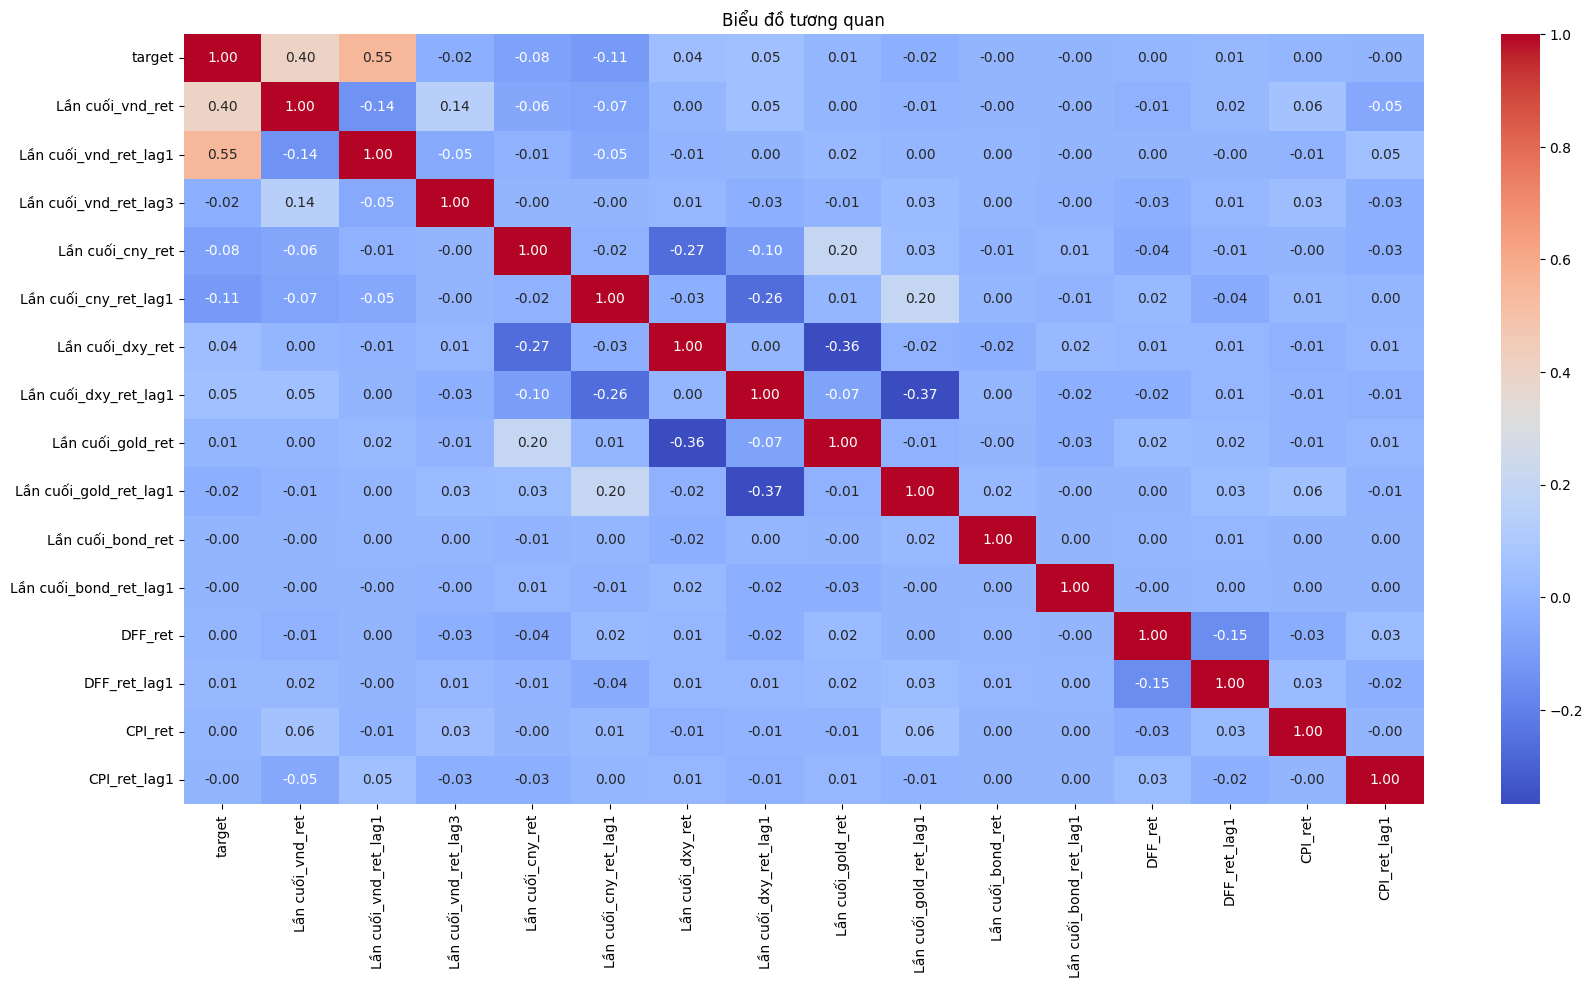

In [17]:

corr = df[important_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Biểu đồ tương quan')
plt.show()

###Bảng thống kê

In [18]:
# Chọn các cột số
df_numeric = df[important_cols].select_dtypes(include = 'number')
print(df_numeric.columns)

Index(['target', 'Lần cuối_vnd_ret', 'Lần cuối_vnd_ret_lag1',
       'Lần cuối_vnd_ret_lag3', 'Lần cuối_cny_ret', 'Lần cuối_cny_ret_lag1',
       'Lần cuối_dxy_ret', 'Lần cuối_dxy_ret_lag1', 'Lần cuối_gold_ret',
       'Lần cuối_gold_ret_lag1', 'Lần cuối_bond_ret', 'Lần cuối_bond_ret_lag1',
       'DFF_ret', 'DFF_ret_lag1', 'CPI_ret', 'CPI_ret_lag1'],
      dtype='object')


In [19]:
mean = df_numeric.mean()
median = df_numeric.median()
mode = df_numeric.mode().iloc[0]
min = df_numeric.min()
max = df_numeric.max()
Q1 = df_numeric.quantile(0.25)
Q2 = df_numeric.quantile(0.5)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
std = df_numeric.std()
var = df_numeric.var()
# Tạo bảng thống kê
def thong_ke(mean,median,mode,min,max,Q1,Q2,Q3,IQR,std,var):
  data = {'Mean': list(mean),
          'Median': list(median),
          'Mode': list(mode),
          'Min': list(min),
          'Max': list(max),
          'Q1': list(Q1),
          'Q2': list(Q2),
          'Q3': list(Q3),
          'IQR': list(IQR),
          'std': list(std),
          'var': list(var)
          }
  df = pd.DataFrame(data)
  df.index = df_numeric.columns
  df_complete = df.transpose()
  return df
df_complete = thong_ke(mean,median,mode,min,max,Q1,Q2,Q3,IQR,std,var)

In [20]:
df_complete = df_complete.round(4)
df_complete

,Mean,Median,Mode,Min,Max,Q1,Q2,Q3,IQR,std,var
target,0.0001,0.0000,0.0,-0.0151,0.0241,-0.0002,0.0000,0.0002,0.0004,0.0011,0.0000
Lần cuối_vnd_ret,0.0001,0.0000,0.0,-0.0456,0.0479,-0.0004,0.0000,0.0004,0.0008,0.0021,0.0000
Lần cuối_vnd_ret_lag1,0.0001,0.0000,0.0,-0.0456,0.0626,-0.0004,0.0000,0.0004,0.0008,0.0023,0.0000
Lần cuối_vnd_ret_lag3,0.0001,0.0000,0.0,-0.0456,0.0626,-0.0004,0.0000,0.0004,0.0008,0.0024,0.0000
Lần cuối_cny_ret,-0.0000,0.0000,0.0,-0.0180,0.0161,-0.0007,0.0000,0.0007,0.0014,0.0021,0.0000
Lần cuối_cny_ret_lag1,-0.0000,0.0000,0.0,-0.0180,0.0161,-0.0007,0.0000,0.0007,0.0014,0.0021,0.0000
Lần cuối_dxy_ret,0.0001,0.0000,0.0,-0.0302,0.0256,-0.0025,0.0000,0.0027,0.0053,0.0047,0.0000
Lần cuối_dxy_ret_lag1,0.0001,0.0000,0.0,-0.0302,0.0256,-0.0025,0.0000,0.0027,0.0053,0.0048,0.0000
Lần cuối_gold_ret,0.0002,0.0003,0.0,-0.0934,0.0897,-0.0047,0.0003,0.0057,0.0104,0.0108,0.0001
Lần cuối_gold_ret_lag1,0.0002,0.0002,0.0,-0.0934,0.0897,-0.0044,0.0002,0.0054,0.0099,0.0107,0.0001


###Khám phá dữ liệu

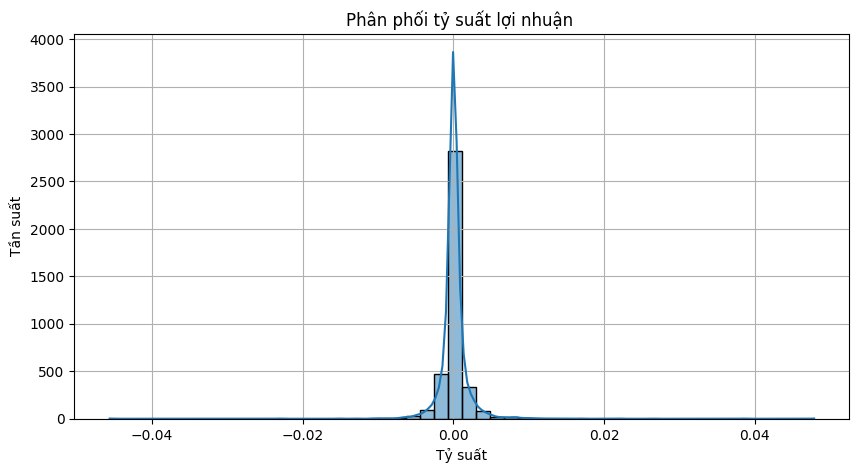

In [21]:
# Biểu đồ Histogram phân phối tỷ suất lợi nhuận
plt.figure(figsize=(10, 5))
sns.histplot(df['Lần cuối_vnd_ret'], bins=50, kde=True)
plt.title('Phân phối tỷ suất lợi nhuận ')
plt.xlabel('Tỷ suất')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()

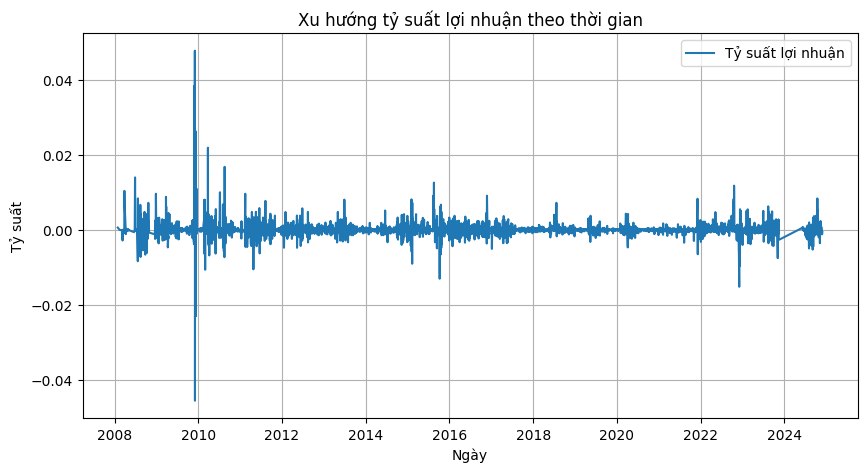

In [22]:
# Biểu đồ Đường tỷ suất lợi nhuận qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Lần cuối_vnd_ret'], label='Tỷ suất lợi nhuận')
plt.title('Xu hướng tỷ suất lợi nhuận theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Tỷ suất')
plt.legend()
plt.grid(True)
plt.show()

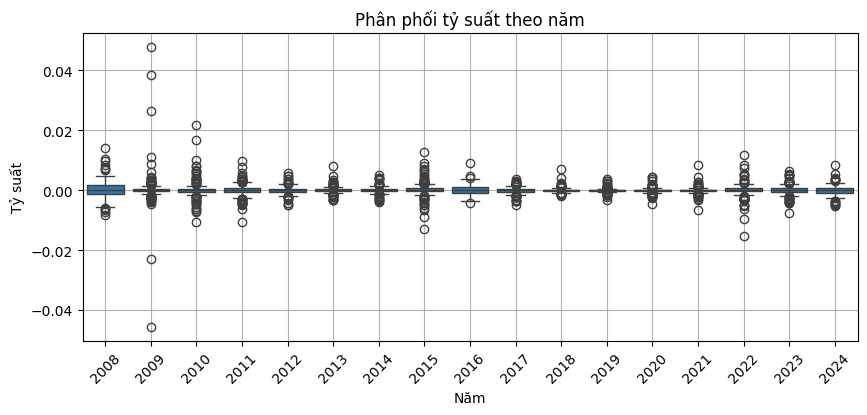

In [23]:
# Tạo cột 'Năm' từ index nếu chưa có
if 'Năm' not in df.columns:
    df['Năm'] = df.index.year

# Biểu đồ Boxplot phân phối tỷ suất theo năm
plt.figure(figsize=(10, 4))
sns.boxplot(x='Năm', y='Lần cuối_vnd_ret', data=df)
plt.title('Phân phối tỷ suất theo năm')
plt.xlabel('Năm')
plt.ylabel('Tỷ suất')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Xóa cột 'Năm' đã thêm vào DataFrame nếu không cần nữa
df.drop(columns=['Năm'], inplace=True, errors='ignore')


##Phân tích dự báo


In [24]:
feature_cols = [
    'Lần cuối_vnd_ret_lag1',
    'Lần cuối_vnd_ret_lag3',
    'Lần cuối_cny_ret_lag1',
    'Lần cuối_dxy_ret_lag1',
    'Lần cuối_gold_ret_lag1',
    'Lần cuối_bond_ret_lag1',
    'DFF_ret_lag1'
]


X = df[feature_cols]
y = df['target']


###Chia tập dữ liệu

In [25]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

###Xây dựng và huấn luyện mô hình

In [26]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_split=30,
    min_samples_leaf=15,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=15,
                      min_samples_split=30, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [27]:
y_pred = model.predict(X_test)

###Đánh giá mô hình

In [28]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 ): {r2:.4f}")

Mean Absolute Error (MAE): 0.0006
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0010
R-squared (R2 ): 0.1929


In [29]:
residuals = y_test - y_pred

In [30]:
# Tính r2 trên tập huấn luyện
y_pred_train_log = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train_log)
# Tính r2 trên tập kiểm tra
y_pred_test_log = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test_log)
print(f"R^2 trên tập Huấn luyện (Train): {r2_train:.4f}")
print(f"R^2 trên tập Kiểm tra (Test): {r2_test:.4f}")

R^2 trên tập Huấn luyện (Train): 0.2011
R^2 trên tập Kiểm tra (Test): 0.1929


###Kiểm định chéo

In [31]:
k_folds = 10
# 1. R2
r2_cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='r2',
    cv=k_folds,
    n_jobs=-1
)
# 2. MSE (sklearn trả về giá trị âm → phải đổi dấu)
mse_cv = -cross_val_score(
    model,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=k_folds,
    n_jobs=-1
)
# 3. MAE (sklearn trả về giá trị âm → phải đổi dấu)
mae_cv = -cross_val_score(
    model,
    X_train,
    y_train,
    scoring='neg_mean_absolute_error',
    cv=k_folds,
    n_jobs=-1
)
# Tạo DataFrame tổng hợp
df_result = pd.DataFrame({
    'R2': r2_cv,
    'RMSE': mse_cv,
    'MAE': mae_cv
})
print(f"R² CV Trung bình : {r2_cv.mean():.4f}")
print(f"R² Std Dev       : {r2_cv.std():.4f}")

print(f"MSE Trung bình  : {mse_cv.mean():.4f}")
print(f"MSE Std Dev     : {mse_cv.std():.4f}")

print(f"MAE Trung bình   : {mae_cv.mean():.4f}")
print(f"MAE Std Dev      : {mae_cv.std():.4f}")

df_result

R² CV Trung bình : 0.1562
R² Std Dev       : 0.1000
MSE Trung bình  : 0.0008
MSE Std Dev     : 0.0007
MAE Trung bình   : 0.0004
MAE Std Dev      : 0.0002


,R2,RMSE,MAE
0,0.259206,0.001183,0.000629
1,0.057840,0.002686,0.000992
2,0.194623,0.000657,0.000423
3,0.210324,0.000412,0.000271
4,0.217384,0.000476,0.000297
5,0.253200,0.000846,0.000505
6,0.098251,0.000644,0.000418
7,0.179087,0.000350,0.000213
8,-0.084156,0.000357,0.000210
9,0.176430,0.000473,0.000270


In [32]:
# Tạo DataFrame so sánh cho tập huấn luyện
df_train_comparison = pd.DataFrame({
    'Thực tế': y_train,
    'Dự đoán': y_pred_train_log,
    'Chênh lệch': y_train - y_pred_train_log
})

print("Bảng so sánh Giá trị thực tế và Dự đoán trên Tập Huấn luyện:")
display(df_train_comparison.head())

Bảng so sánh Giá trị thực tế và Dự đoán trên Tập Huấn luyện:


,Thực tế,Dự đoán,Chênh lệch
Ngày,,,
2008-01-28,-0.000146,-0.000027,-0.000119
2008-02-13,-0.000209,0.000010,-0.000219
2008-02-25,0.000000,0.000033,-0.000033
2008-03-03,-0.000209,0.000009,-0.000219
2008-03-06,-0.000251,0.000023,-0.000275


In [33]:
# Tạo DataFrame so sánh cho tập kiểm tra
df_test = pd.DataFrame({
    'Thực tế': y_test,
    'Dự đoán': y_pred_test_log,
    'Chênh lệch ': y_test - y_pred_test_log
})

print("Bảng so sánh giá trị thực tế và Dự đoán trên Tập Kiểm tra:")
display(df_test.head(5))

Bảng so sánh giá trị thực tế và Dự đoán trên Tập Kiểm tra:


,Thực tế,Dự đoán,Chênh lệch
Ngày,,,
2021-04-29,0.000174,0.000029,0.000145
2021-04-30,0.000101,0.000021,0.000081
2021-05-03,-0.000058,0.000070,-0.000128
2021-05-04,0.000087,0.000095,-0.000009
2021-05-05,0.000188,0.000073,0.000115


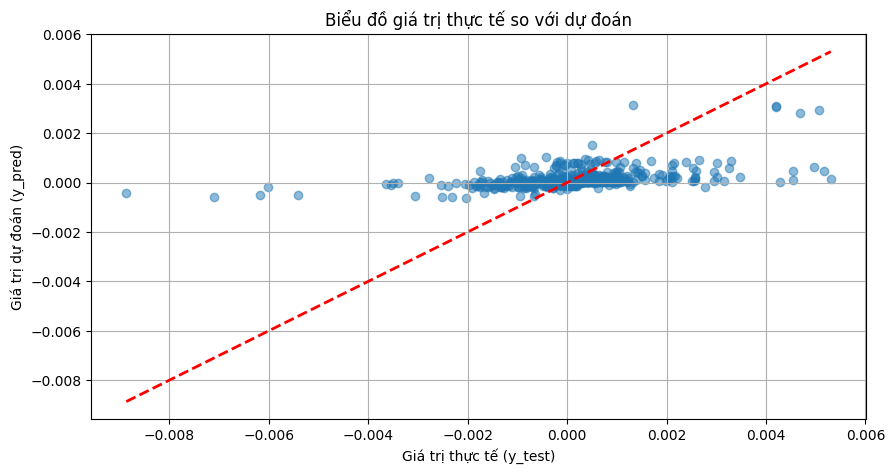

In [34]:
# Biểu đồ giá trị thực tế so với dự đoán
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế (y_test)')
plt.ylabel('Giá trị dự đoán (y_pred)')
plt.title('Biểu đồ giá trị thực tế so với dự đoán')
plt.grid(True)
plt.show()

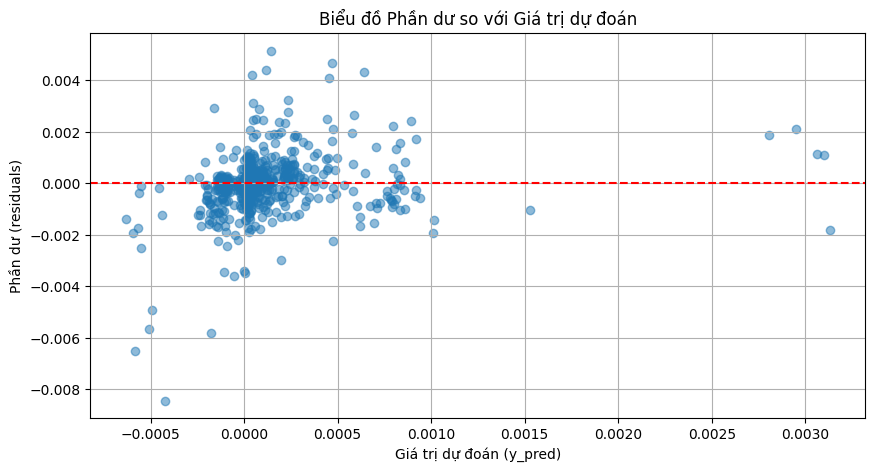

In [35]:
#Biểu đồ Phần dư so với Giá trị dự đoán
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Giá trị dự đoán (y_pred)')
plt.ylabel('Phần dư (residuals)')
plt.title('Biểu đồ Phần dư so với Giá trị dự đoán')
plt.grid(True)
plt.show()

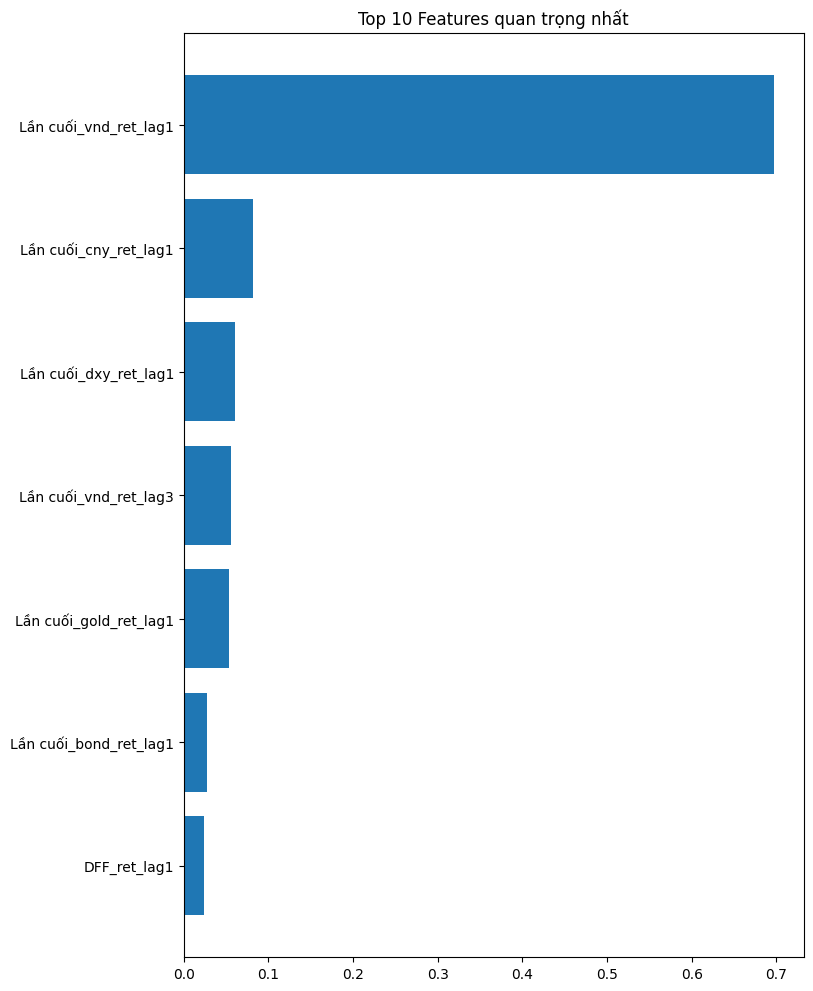

In [36]:
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,12))
plt.barh(feat_imp['feature'].head(20),
         feat_imp['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 10 Features quan trọng nhất")
plt.show()

###Lưu mô hình


In [37]:
joblib.dump(model, 'random_forest_model.joblib')
print("Mô hình đã được lưu thành công dưới tên 'random_forest_model.joblib'")

Mô hình đã được lưu thành công dưới tên 'random_forest_model.joblib'


###Lưu file đã xử lý

In [38]:
df.to_csv('df_processed_with_features.csv', index=True)
print("DataFrame đã được lưu thành công dưới tên 'df_processed_with_features.csv'")

DataFrame đã được lưu thành công dưới tên 'df_processed_with_features.csv'
